In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
from lal import MSUN_SI
from lalsimulation import SimInspiralTransformPrecessingNewInitialConditions

from cogwheel.gw_prior import UniformDetectorFrameMassesPrior
from cogwheel.gw_prior import UniformEffectiveSpinPrior
from cogwheel.gw_prior import UniformDiskInplaneSpinsIsotropicInclinationPrior
from cogwheel.gw_utils import m1m2_to_mchirp
from cogwheel import utils

In [ ]:
def create_cogwheel_importance_sampled_bank(
    n_samples, q_min, m_min, m_max, inc_faceon_factor, f_ref, seed=None
):
    """
    Create importance sampled bank using cogwheel priors.

    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    q_min : float
        Minimum mass ratio
    m_min, m_max : float
        Mass range (solar masses)
    inc_faceon_factor : float
        Factor for face-on inclination preference (1.0 = isotropic)
    f_ref : float
        Reference frequency
    seed : int, optional
        Random seed

    Returns
    -------
    pd.DataFrame
        DataFrame with samples and importance sampling weights
    """

    # Set up random number generator
    if seed is not None:
        np.random.seed(seed)

    # Create physical priors (what we want to sample from)
    mchirp_min = m1m2_to_mchirp(m_min, m_min * q_min)
    mchirp_max = m1m2_to_mchirp(m_max, m_max)

    physical_mass_prior = UniformDetectorFrameMassesPrior(
        mchirp_range=(mchirp_min, mchirp_max), q_min=q_min
    )
    physical_spin_prior = UniformEffectiveSpinPrior()
    physical_inclination_prior = UniformDiskInplaneSpinsIsotropicInclinationPrior()

    # Generate samples using drawing priors
    u = qmc.Halton(d=9, seed=seed).random(n_samples).T

    # Draw masses (log-uniform in m1, m2)
    logm1 = np.log(m_min) + u[0] * np.log(m_max / m_min)
    logm2 = logm1 + (1 - u[1]) * np.log(q_min)
    m1, m2 = np.exp(logm1), np.exp(logm2)

    # Draw aligned spins (same as physical prior)
    chieff = -1 + 2 * u[2]
    cumchidiff = u[3]
    d = physical_spin_prior.transform(chieff, cumchidiff, m1, m2)
    s1z, s2z = d["s1z"], d["s2z"]

    # Draw inclination and in-plane spins
    phi_jl_hat_samples = u[4] * 2 * np.pi
    phi12_samples = u[5] * 2 * np.pi
    cums1r_s1z_samples, cums2r_s2z_samples = u[6], u[7]

    # Draw inclination using biased CDF (same as original)
    inc_factor = (inc_faceon_factor - 1) / (inc_faceon_factor + 1)
    theta_jn_range = np.linspace(0, np.pi, 10**4)
    theta_jn_cdf = (
        theta_jn_range + inc_factor / 2 * np.sin(2 * theta_jn_range)
    ) / np.pi
    theta_jn_samples = theta_jn_range[np.searchsorted(theta_jn_cdf, u[8])]
    costheta_jn_samples = np.cos(theta_jn_samples)

    # Transform spins using physical prior (same as original)
    chi1, tilt1 = physical_inclination_prior._spin_transform(cums1r_s1z_samples, s1z)
    chi2, tilt2 = physical_inclination_prior._spin_transform(cums2r_s2z_samples, s2z)

    phi_jl_samples = (phi_jl_hat_samples + np.pi * (costheta_jn_samples < 0)) % (
        2 * np.pi
    )
    theta_jn_samples = np.arccos(costheta_jn_samples)

    # Use LALSimulation to get final parameters (same as original)
    iota, s1x_n, s1y_n, s1z, s2x_n, s2y_n, s2z = np.array(
        [
            SimInspiralTransformPrecessingNewInitialConditions(
                theta_jn_samples[i],
                phi_jl_samples[i],
                tilt1[i],
                tilt2[i],
                phi12_samples[i],
                chi1[i],
                chi2[i],
                m1[i] * MSUN_SI,
                m2[i] * MSUN_SI,
                f_ref,
                phiRef=0.0,
            )
            for i in range(n_samples)
        ]
    ).T

    # Calculate importance sampling weights
    log_weights = np.zeros(n_samples)

    # Mass weights: physical prior / drawing prior
    for i in range(n_samples):
        # Physical prior density
        mchirp = m1m2_to_mchirp(m1[i], m2[i])
        lnq = np.log(m2[i] / m1[i])
        log_physical = physical_mass_prior.lnprior(mchirp, lnq)

        # Drawing prior density (log-uniform)
        log_drawing = -np.log(np.log(m_max / m_min) * np.log(1 / q_min) * m1[i] * m2[i])

        # Jacobian for coordinate transformation
        jacobian_det = mchirp / m1[i] / m2[i]
        log_jacobian = np.log(jacobian_det)

        log_weights[i] += log_physical - log_drawing + log_jacobian

    # Inclination weights: physical prior / drawing prior
    for i in range(n_samples):
        # Physical prior: uniform in cos(theta_jn)
        log_physical = 0.0  # uniform, so log density is constant

        # Drawing prior: biased towards face-on
        inc_factor = (inc_faceon_factor - 1) / (inc_faceon_factor + 1)
        log_drawing = np.log((1 + inc_factor * np.cos(2 * theta_jn_samples[i])) / np.pi)

        log_weights[i] += log_physical - log_drawing

    # Create DataFrame
    samples = pd.DataFrame(
        {
            "m1": m1,
            "m2": m2,
            "s1z": s1z,
            "s1x_n": s1x_n,
            "s1y_n": s1y_n,
            "s2z": s2z,
            "s2x_n": s2x_n,
            "s2y_n": s2y_n,
            "iota": iota,
            "log_prior_weights": log_weights,
        }
    )

    return samples

In [24]:
# Example usage with notebook parameters:

samples = create_cogwheel_importance_sampled_bank(
    n_samples=2**16,
    q_min=1 / 6,
    m_min=50,
    m_max=100,
    inc_faceon_factor=1.0,
    f_ref=50.0,
    seed=42,
)

print(f"Generated {len(samples)} samples")


Generated 65536 samples


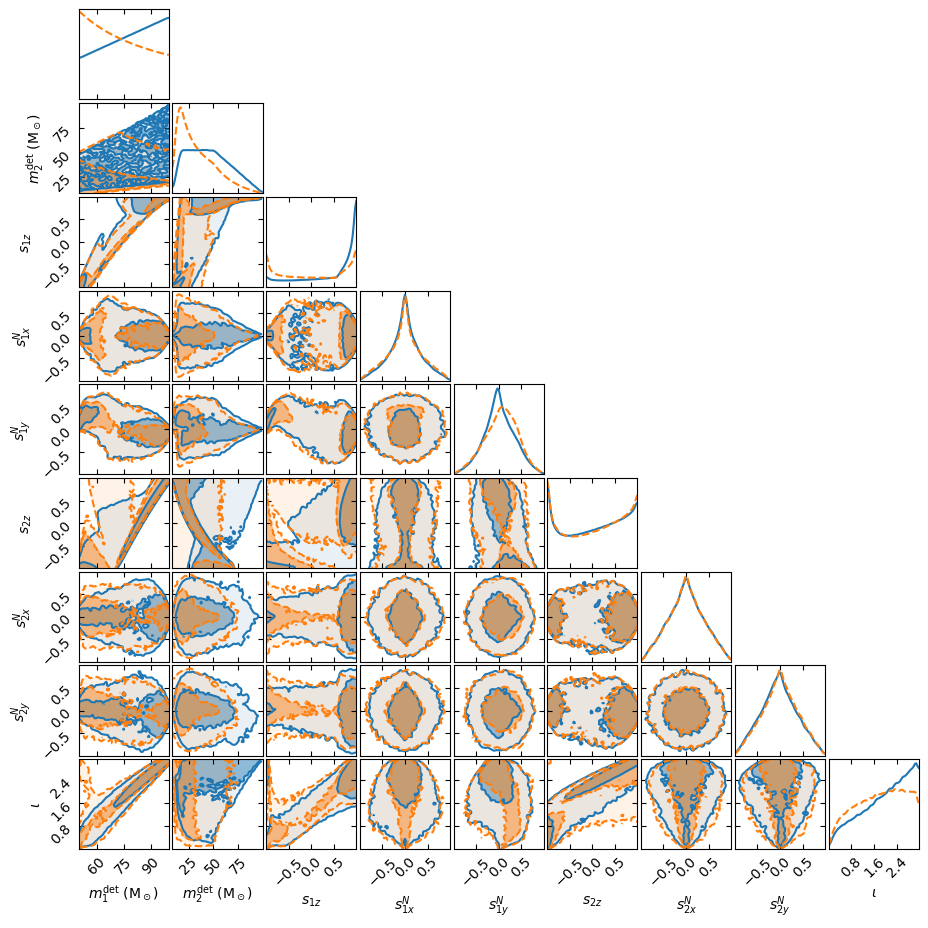

In [25]:
from cogwheel import gw_plotting

samples["weights"] = utils.exp_normalize(samples["log_prior_weights"].values)
samples_unweighted = samples.copy()
samples_unweighted["weights"] = 1.0
gw_plotting.MultiCornerPlot(
    [samples, samples_unweighted],
    params=[c for c in samples.columns if "weights" not in c],
    smooth=1.0,
).plot()